# Arm Motion Modeling

## System Description

A double-pendulum system hanging in gravity is shown in the figure above. $q=[\theta_1, \theta_2]$ are the system configuration variables. We assume the z-axis is pointing out from the screen/paper, thus the positive direction of rotation is counter-clockwise.
The solution steps are:
1. Computing the Lagrangian of the system. 
2. Computing the Euler-Lagrange equations, and solve them for $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
3. Numerically evaluating the solutions for ${\tau}_1$ and ${\tau}_2$, and simulating the system for ${\theta}_1$, ${\theta}_2$, $\dot{\theta}_1$, $\dot{\theta}_2$, $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
4. Animating the simulation.

In [101]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='./double-pendulum-diagram.png' width=450' height='300'></table>"))

## Import Libraries and Define System Constants

Import libraries:

In [102]:
# Imports required for data processing
import os
import csv

# Imports required for dynamics calculations
import sympy
from sympy.abc import t
from sympy import symbols, Eq, Function, solve, sin, cos, Matrix, Subs, substitution, Derivative, simplify, symbols, lambdify
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Imports required for animation
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objects as go


Parameters:

In [103]:
use_my_data = True
use_double_pendulum = False

Define the system's constants:

In [104]:
if use_my_data:
    # Masses, length and center-of-mass positions (calculated using the lab measurements)
    # Mass calculations (mass unit is kg) 
    m_body = 53
    m_u = 0.028 * m_body                     # Average upper arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    m_l = 0.7395                             # Average lower prosthetics weights, calculated using lab measurements  
    # m_lower = 0.022 * m_body               # Average lower arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    # Arm length calculations (length unit is m) 
    H_body = 1.62
    L_u = 0.186 * H_body                     # Average upper arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    # L_l = (0.146 + 0.108) * H_body         # Average lower arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    L_l = 0.42                               # Average lower prosthetics length, calculated using lab measurements 

    # Arm center of mass length calculations (length unit is m) 
    L_u_c = 0.436 * L_u                      # Average upper arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
    L_l_c = 0.2388                           # Average lower prosthetics length from elbow to center of mass,
                                             # calculated using lab measurements 
    # L_l_c = 0.682 * L_l                    # Average lower arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
else:
    # Masses, length and center-of-mass positions (calculated using the lab measurements)
    # Mass calculations (mass unit is kg) 
    m_body = 90.6                            # Average weights for American adult male
                                             # from "Anthropometric Reference Data for Children and Adults:
                                             # United States, 2015–2018"
    m_body_dict = {'ID': 51.0, 'JD': 79.5, 'JR': 76.0, 'KS': 59.3, 'KW': 63.8, 'LC': 61.2,
                   'LD': 97.3, 'LS': 82.2, 'MK': 93.5, 'MV': 98.5, 'SM': 68.5, 'TD': 70.0,
                   'TM': 66.2}

    m_u = 0.028 * m_body                     # Average upper arm weights relative to body weight, from “Biomechanics
                                             # and Motor Control of Human Movement” by David Winter (2009), 4th edition
    m_u_dict = {'ID': 0.028 * m_body_dict['ID'], 'JD': 0.028 * m_body_dict['JD'],
                'JR': 0.028 * m_body_dict['JR'], 'KS': 0.028 * m_body_dict['KS'],
                'KW': 0.028 * m_body_dict['KW'], 'LC': 0.028 * m_body_dict['LC'],
                'LD': 0.028 * m_body_dict['LD'], 'LS': 0.028 * m_body_dict['LS'],
                'MK': 0.028 * m_body_dict['MK'], 'MV': 0.028 * m_body_dict['MV'],
                'SM': 0.028 * m_body_dict['SM'], 'TD': 0.028 * m_body_dict['TD'],
                'TM': 0.028 * m_body_dict['TM']}

    m_l = 0.7395                             # Average lower prosthetics weights, calculated using lab measurements  

    # Arm length calculations (length unit is m) 
    H_body = 1.769                           # Average height for American adult male, from “Height and body-mass 
                                             # index trajectories of school-aged children and adolescents from 
                                             # 1985 to 2019 in 200 countries and territories: a pooled analysis 
                                             # of 2181 population-based studies with 65 million participants”
    H_body_dict = {'ID': 1.620, 'JD': 1.760, 'JR': 1.770, 'KS': 1.640, 'KW': 1.620, 'LC': 1.580,
                   'LD': 1.875, 'LS': 1.635, 'MK': 1.780, 'MV': 1.805, 'SM': 1.790, 'TD': 1.690,
                   'TM': 1.735}

    L_u = 0.186 * H_body                     # Average upper arm length relative to body height
                                             # from “Biomechanics and Motor Control of Human Movement” by David
                                             # Winter (2009), 4th edition
    L_u_dict = {'ID': 0.186 * H_body_dict['ID'], 'JD': 0.186 * H_body_dict['JD'],
                'JR': 0.186 * H_body_dict['JR'], 'KS': 0.186 * H_body_dict['KS'],
                'KW': 0.186 * H_body_dict['KW'], 'LC': 0.186 * H_body_dict['LC'],
                'LD': 0.186 * H_body_dict['LD'], 'LS': 0.186 * H_body_dict['LS'],
                'MK': 0.186 * H_body_dict['MK'], 'MV': 0.186 * H_body_dict['MV'],
                'SM': 0.186 * H_body_dict['SM'], 'TD': 0.186 * H_body_dict['TD'],
                'TM': 0.186 * H_body_dict['TM']}

    L_l = 0.42                               # Average lower prosthetics length, calculated using lab measurements

    # Arm center of mass length calculations (length unit is m) 
    L_u_c = 0.436 * L_u                      # Average upper arm length from shoulder to center of mass relative
                                             # to upper arm length, from “Biomechanics and Motor Control of Human
                                             # Movement” by David Winter (2009), 4th edition
    L_u_c_dict = {'ID': 0.436 * L_u_dict['ID'], 'JD': 0.436 * L_u_dict['JD'],
                  'JR': 0.436 * L_u_dict['JR'], 'KS': 0.436 * L_u_dict['KS'],
                  'KW': 0.436 * L_u_dict['KW'], 'LC': 0.436 * L_u_dict['LC'],
                  'LD': 0.436 * L_u_dict['LD'], 'LS': 0.436 * L_u_dict['LS'],
                  'MK': 0.436 * L_u_dict['MK'], 'MV': 0.436 * L_u_dict['MV'],
                  'SM': 0.436 * L_u_dict['SM'], 'TD': 0.436 * L_u_dict['TD'],
                  'TM': 0.436 * L_u_dict['TM']}
    L_l_c = 0.2388                           # Average lower prosthetics length from elbow to center of mass,
                                             # calculated using lab measurements 

## Extracting Data

Extracting angles data and computing angular velocities and angular accelerations from the angles:

In [105]:
import sympy as sym

# Does not work with run all, will be cut off short while generating trajectory
# Parameters
size = 3998 # how many data points in ms
frame_rate = 100
# Define variables
t = sym.Symbol(r't')

# Define the function
f = .5*sin(t*4)

# And its dervatives
df = sym.diff(f)
ddf = sym.diff(df)

# Lambdify
lam1 = sym.lambdify('t', f)
lam2 = sym.lambdify('t', df)
lam3 = sym.lambdify('t', ddf)

# Open file
Angle = open("CSV_Converted_Files/angle.csv",'w')
Vel = open("CSV_Converted_Files/velocity.csv",'w')
Acc = open("CSV_Converted_Files/acceleration.csv",'w')

# Create the trajectory and write it to the file
for i in range(size):
    lines = [str(lam1(i/100)) + '\n', str(lam2(i/100)) + '\n', str(lam3(i/100)) + '\n']
    Angle.write(lines[0])
    Vel.write(lines[1])
    Acc.write(lines[2])


In [106]:
def calculate_vel(ang_list, time_list, index):
    return ((ang_list[index + 1] - ang_list[index])
          / (time_list[index + 1] - time_list[index]))


def calculate_acc(vel_list, time_list, index):
    return ((vel_list[index + 1] - vel_list[index])
          / (time_list[index + 1] - time_list[index]))


data_csv_dir = 'CSV_Converted_Files'
print("current directory: ", os.getcwd())

if use_my_data:
    frame_frequency = frame_rate
    

    walking_vel_list = []
    time_list = []
    elbow_ang_list = []
    elbow_vel_list = []
    elbow_acc_list = []
    elbow_acc_data_list = []

    file_list = os.listdir(data_csv_dir)
    file_list.sort()

    print(file_list)
                
    for file in file_list:

        file_name = file[:-4]

        frame = 0
        file_time_list = []
        file_elbow_ang_list, file_elbow_vel_list, file_elbow_acc_list, time_list = [], [], [], []

        # Cutting out weird data behavior on data edges
        data_path = os.path.join(data_csv_dir, file)
        data_rows = open(data_path).read().strip().split("\n")
        
        # Record data
        if file_name == 'angle':
            for row in data_rows:
                splitted_row = row.strip()
                file_elbow_ang_list = splitted_row
                elbow_ang_list.append(float(file_elbow_ang_list))
                time_list.append(frame/frame_frequency)
                frame += 1

        elif file_name == 'velocity':
            for row in data_rows:
                splitted_row = row.strip()
                file_elbow_vel_list = splitted_row
                elbow_vel_list.append(float(file_elbow_vel_list))
                time_list.append(frame/frame_frequency)
                frame += 1

        elif file_name == 'acceleration':
            for row in data_rows:
                splitted_row = row.strip()
                file_elbow_acc_list = splitted_row
                elbow_acc_list.append(float(file_elbow_acc_list))
                time_list.append(frame/frame_frequency)
                frame += 1


    # print(elbow_ang_list)
    # print(elbow_vel_list)
    # print(elbow_acc_list)


current directory:  /Users/michaeljenz/zephyrproject/zephyr/prosthetic_arm_control
['acceleration.csv', 'angle.csv', 'velocity.csv']


## System Modeling - Single Pendulum

Computing the Lagrangian of the system:

In [107]:
if not use_double_pendulum:
    m, g, R, R_c = symbols(r'm, g, R, R_c')

    # The system torque variables as function of t
    tau = Function(r'tau')(t)

    # The system configuration variables as function of t
    theta = Function(r'theta')(t)

    # The velocity as derivative of position wrt t
    theta_dot = theta.diff(t)

    # The acceleration as derivative of velocity wrt t
    theta_ddot = theta_dot.diff(t)

    # Converting the polar coordinates to cartesian coordinates
    x = R_c * sin(theta)
    y = -R_c * cos(theta)

    # Calculating the kinetic and potential energy of the system
    KE = 1/2 * m * ((x.diff(t))**2 + (y.diff(t))**2)
    PE = m * g * y

    # Computing the Lagrangian
    L = simplify(KE - PE)
    Lagrange = Function(r'L')(t)
    display(Eq(Lagrange, L))

Eq(L(t), R_c*m*(0.5*R_c*Derivative(theta(t), t)**2 + g*cos(theta(t))))

Computing the Euler-Lagrange equations:

In [108]:
if not use_double_pendulum:
    # Define the derivative of L wrt the functions: x, xdot
    L_dtheta = L.diff(theta)
    L_dtheta_dot = L.diff(theta_dot)

    # Define the derivative of L_dxdot wrt to time t
    L_dtheta_dot_dt = L_dtheta_dot.diff(t)

    # Define the right hand side of the the Euler-Lagrange as a matrix
    rhs = simplify(L_dtheta_dot_dt - L_dtheta)

    # Define the left hand side of the the Euler-Lagrange as a Matrix
    lhs = tau

    # Compute the Euler-Lagrange equations as a matrix
    EL_eqns = Eq(lhs, rhs)

    print('Euler-Lagrange matrix for this systems:')
    display(EL_eqns)

Euler-Lagrange matrix for this systems:


Eq(tau(t), R_c*m*(1.0*R_c*Derivative(theta(t), (t, 2)) + g*sin(theta(t))))

Simulating the system:

In [109]:
if not use_double_pendulum:
    # Substitute the derivative variables with a dummy variables and plug-in the constants
    solution_subs = rhs

    theta_dot_dummy = symbols('thetadot')
    theta_ddot_dummy = symbols('thetaddot')

    solution_subs = solution_subs.subs([(g, 9.81)])

    solution_subs = solution_subs.subs([((theta.diff(t)).diff(t), theta_ddot_dummy)])
    solution_subs = solution_subs.subs([(theta.diff(t), theta_dot_dummy)])

    # Lambdify the thetas and its derivatives
    func = lambdify([theta, theta_dot_dummy, theta_ddot_dummy,
                     m, R, R_c], solution_subs, modules = sympy)

    # Initialize the torque and power lists
    elbow_tau_list = []
    elbow_current_list = []
    elbow_power_list = []

    motor_kv = 115
    torque_const = 8.27 / motor_kv

    # Initialize the torque and power lists
    tau_list = []
    current_list = []
    power_list = []

    t_list = time_list
    theta_list = elbow_ang_list
    dtheta_list = elbow_vel_list
    ddtheta_list = elbow_acc_list

    # Plug-in the angles, angular velocities and angular accelerations for every time step to find the torques
    for j in range(len(t_list)):
        tau_list.append(func(theta_list[j], dtheta_list[j], ddtheta_list[j], m_l, L_l, L_l_c))
        # print(tau_list[j])
        # Calculate the current required to reach the required joints torques for every time step
        current_list.append(torque_const * tau_list[j])

        # Calculate the power required to reach the required angular velocities and joints torques for every time step
        power_list.append(dtheta_list[j] * tau_list[j])

    # elbow_tau_list.append(tau_list)
    # elbow_current_list.append(current_list)
    # elbow_power_list.append(power_list)

    # save the torque and acceleration profile
    with open("src/data_profile_sinusoid.c", "w") as data_file:
        data_file.write('#include "data_profile.h"\n\n')
        data_file.write('float Torque_Profile_SIN[DATA_SAMPLES] = {\n')
        list_str = ', \n'.join(map(str, tau_list))  
        data_file.write(list_str)
        data_file.write('\n};\n')
        data_file.write('float Accel_Profile_SIN[DATA_SAMPLES-2] = {\n')
        accel_list_str = ', \n'.join(map(str, tau_list[:-2])) 
        data_file.write(accel_list_str)
        data_file.write('\n};')
        # np.savetxt('data_profile2.c', [p for p in zip(tau_list)], delimiter=',', fmt='%f')
        # np.savetxt('data_profile2.c',['hi','bye'],delimiter=',',fmt='%s')


    # print(f"{walking_vel_list[i]}:\t max angle: {format(max(theta_list), '.3f')}[rad]\t max velocity: {format(max(dtheta_list), '.3f')}[rad/s]\t max torque: {format(max(tau_list), '.3f')}[Nm]\t max power: {format(max(power_list), '.3f')}[W]")

Calculation summary:

In [110]:
if not use_double_pendulum:
    min_elbow_ang_list = []
    max_elbow_tau, max_elbow_power, max_elbow_vel, max_elbow_ang = -10, -10, -10, -10
    min_elbow_tau, min_elbow_power, min_elbow_vel, min_elbow_ang = 0, 0, 0, 0
    max_elbow_tau_index, max_elbow_power_index, max_elbow_vel_index, max_elbow_ang_index = 0, 0, 0, 0
    min_elbow_tau_index, min_elbow_power_index, min_elbow_vel_index, min_elbow_ang_index = 0, 0, 0, 0

    # min_elbow_ang_list.append(min(elbow_ang_list))
    
    # max_elbow_ang = max(elbow_ang_list)
    # max_elbow_ang_index = elbow_ang_list.index(max(elbow_ang_list))
        
    # min_elbow_ang = min(elbow_ang_list)
    # min_elbow_ang_index = elbow_ang_list.index(min(elbow_ang_list))
    
    # max_elbow_vel = max(elbow_vel_list)
    # max_elbow_vel_index = elbow_vel_list.index(max(elbow_vel_list))

    # max_elbow_tau = max(elbow_tau_list)
    # max_elbow_tau_index = elbow_vel_list.index(min(elbow_vel_list))

    # max_elbow_power = max(elbow_power_list)
    # max_elbow_power_index = elbow_power_list.index(max(elbow_power_list))

    # print(f"maximum elbow angle is {format(max_elbow_ang, '.3f')} [rad], in velocity(trial {max_elbow_ang_index})")
    # print(f"minimum elbow angle is {format(min_elbow_ang, '.3f')} [rad], in velocity (trial {min_elbow_ang_index})")
    # print(f"maximum elbow angular velocity is {format(max_elbow_vel, '.3f')} [rad/s] ({format(max_elbow_vel*60/(2*pi), '.3f')} [rpm]), in velocity )")
    # print(f"maximum elbow torque is {format(max_elbow_tau, '.3f')} [Nm], in velocity  (trial {max_elbow_tau_index})")
    # print(f"maximum elbow power is {format(max_elbow_power, '.3f')} [W], in velocity  (trial {max_elbow_power_index})")


    # The torque equations for the maximum power:
    solution_subs = solution_subs.subs([(m, m_l), (R, L_l), (R_c, L_l_c), (g, 9.81)])

    print("\nThe torque equations for the maximum torque:")
    display(Eq(tau, solution_subs))

    # display(elbow_ang_list[max_elbow_tau_index])
    # display(elbow_vel_list[max_elbow_tau_index])
    # display(elbow_acc_list[max_elbow_tau_index])
    # display(elbow_tau_list[max_elbow_tau_index])
    # display(elbow_ang_list[2])
    # display(elbow_tau_list[2])
    
    # trial_num = 5
    # current_elbow_ang_list = elbow_ang_list[0]
    # current_elbow_tau_list = elbow_tau_list[0]

    # elbow_ang_list_turns = [element/(2*pi) for element in current_elbow_ang_list]
    # print(elbow_ang_list_turns)
    # print(current_elbow_tau_list)



The torque equations for the maximum torque:


Eq(tau(t), 0.04217031288*thetaddot + 1.732373406*sin(theta(t)))

Example for the trial with the largest elbow torque & power:

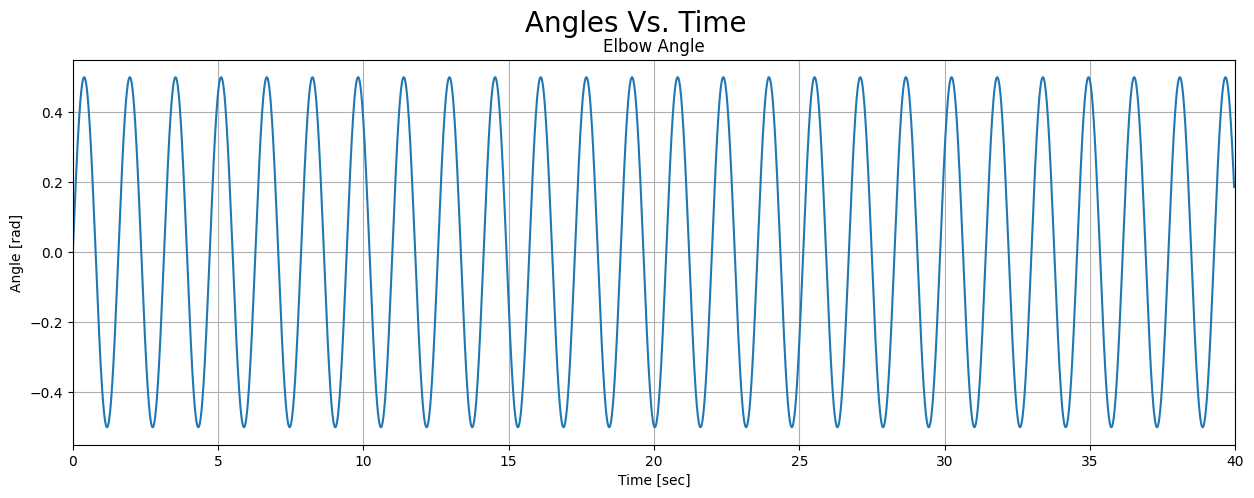

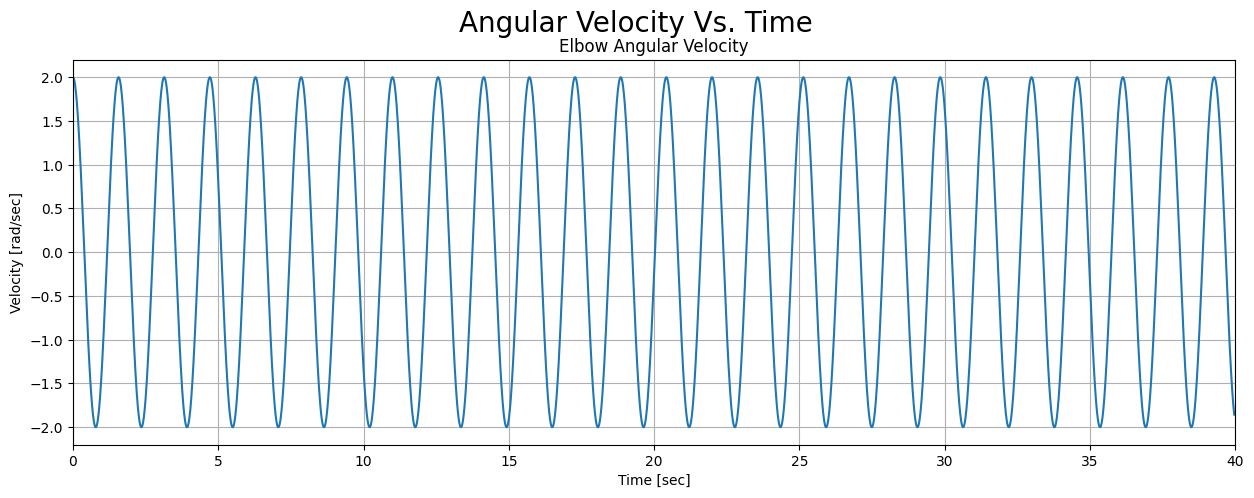

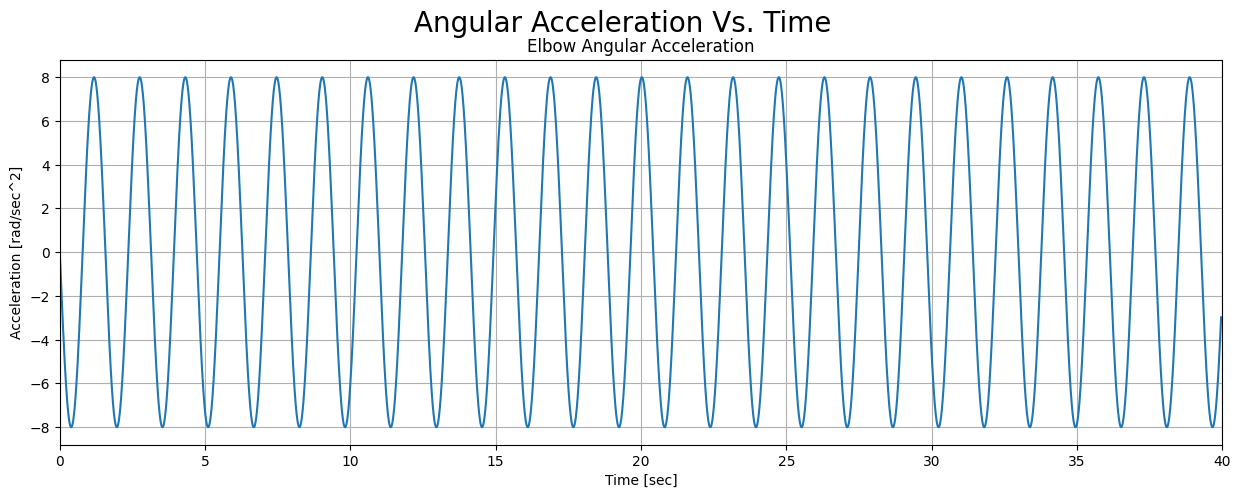

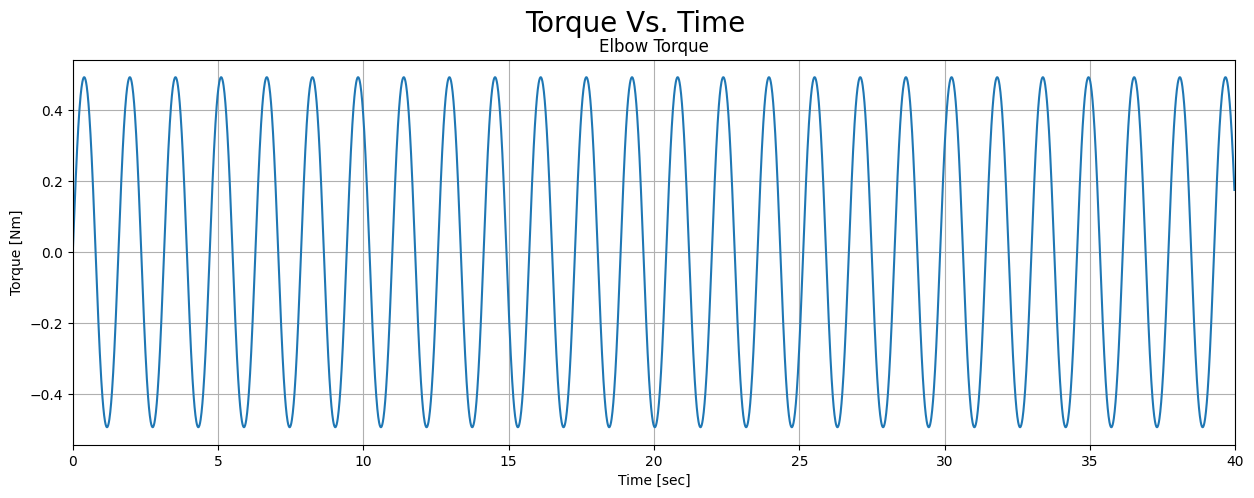

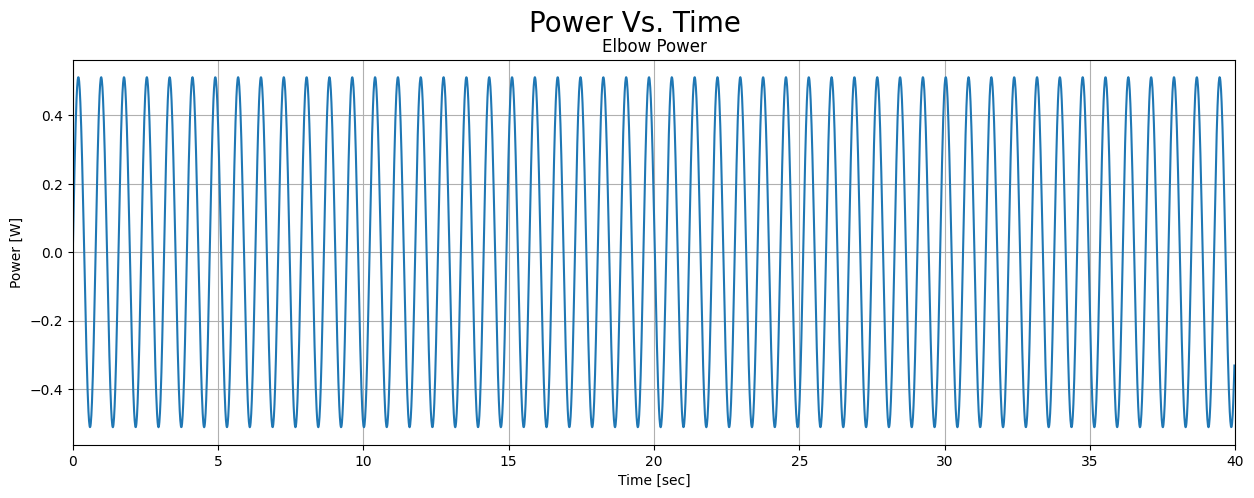

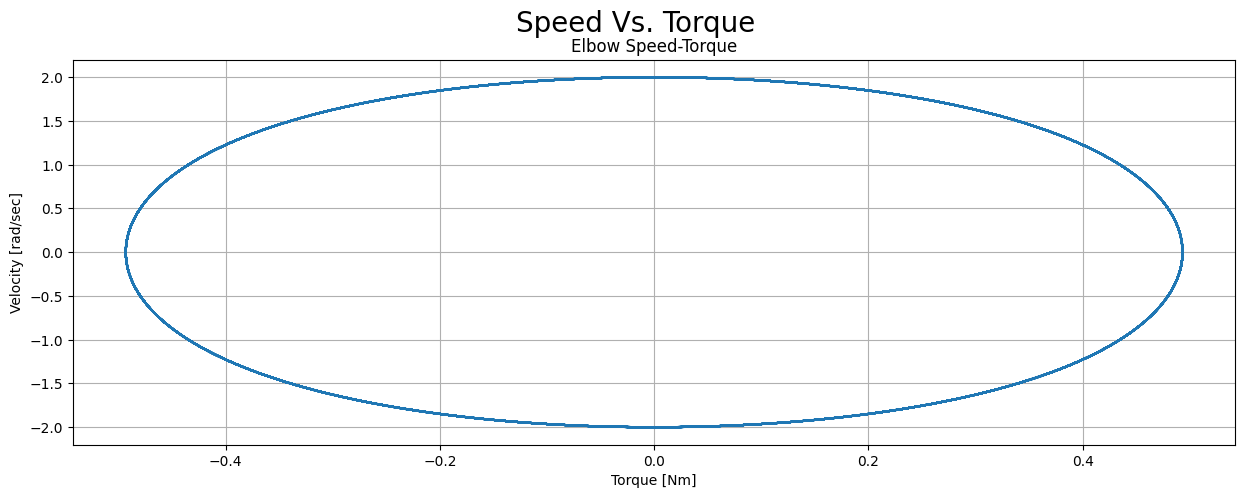

In [111]:
if not use_double_pendulum:
    index = 0
    t_list = time_list
    theta_list = elbow_ang_list
    dtheta_list = elbow_vel_list
    ddtheta_list = elbow_acc_list
    # tau_list = elbow_tau_list
    # current_list = elbow_current_list
    # power_list = elbow_power_list
    

    elbow_acceleration_list = elbow_acc_data_list
    # shoulder_acceleration_list = shoulder_acc_data_list[index]

    # Compute the trajectory of the arm's motion
    N = int((max(t_list))/(1/frame_frequency))

    tvec = np.linspace(min(t_list), max(t_list), N)
    traj = np.zeros((3, N))
    back_traj = np.zeros((3, N))
    acc_traj = np.zeros((2, N))
    partial_traj = np.zeros((3, N))


    for i in range(N):
        traj[0, i] = theta_list[i]
        traj[1, i] = dtheta_list[i]
        traj[2, i] = ddtheta_list[i]

        # back_traj[0, i] = back_rotation_list[i]
        # back_traj[1, i] = back_position_list[i]
        # back_traj[2, i] = back_velocity_list[i]
    for i in range(len(elbow_acceleration_list)):
        acc_traj[0, i] = elbow_acceleration_list[i]

    for i in range(500):
        partial_traj[0, i] = theta_list[i]
        partial_traj[1, i] = dtheta_list[i]
        partial_traj[2, i] = ddtheta_list[i]

    # Calculate the length difference between the time list and the trajectory lists
    diff = (len(t_list) - len(traj[0]))

    # Plot the trajectory lists (angles, velocities, accelerations, torques, and power)
    # plt.figure(figsize=(15,5))
    # plt.suptitle('Maximum Elbow Angle Vs. Walking Velocity', fontsize=20)
    # plt.plot(walking_vel_list[:-1], min_elbow_ang_list[:-1])
    # plt.ylabel('Angle [rad]')
    # plt.xlabel('Time [sec]')
    # plt.xlim([walking_vel_list[0], walking_vel_list[-2]])
    # plt.ylim([min(min_elbow_ang_list), max(min_elbow_ang_list)])
    # plt.grid()
    
    # plt.figure(figsize=(15,5))
    # plt.suptitle('Angles and Back Movement Vs. Time', fontsize=20)
    # plt.plot(t_list[:-diff], traj[0], label="Elbow angle")
    # plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    # plt.ylabel('Angle [rad]')
    # plt.xlabel('Time [sec]')
    # plt.xlim([0, math.ceil(max(tvec))])
    # plt.grid()
    # plt.legend()
    # plt.title('Elbow Angle')
    # plt.show()

    # plt.figure(figsize=(15,5))
    # plt.suptitle('Arm Acceleration and Back Movement Vs. Time', fontsize=20)
    # plt.plot(t_list[:-diff], traj[2], label="Elbow acceleration")
    # plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
    # plt.ylabel('Angle [rad]')
    # plt.xlabel('Time [sec]')
    # plt.xlim([0, math.ceil(max(tvec))])
    # plt.grid()
    # plt.legend()
    # plt.title('Elbow Acceleration')
    # plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angles Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[0])
    plt.ylabel('Angle [rad]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angle')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Velocity Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[1])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angular Velocity')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Angular Acceleration Vs. Time', fontsize=20)
    plt.plot(t_list[:-diff], traj[2])
    plt.ylabel('Acceleration [rad/sec^2]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Angular Acceleration')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Torque Vs. Time', fontsize=20)
    plt.plot(t_list, tau_list)
    plt.ylabel('Torque [Nm]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Torque')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Power Vs. Time', fontsize=20)
    plt.plot(t_list, power_list)
    plt.ylabel('Power [W]')
    plt.xlabel('Time [sec]')
    plt.xlim([0, math.ceil(max(tvec))])
    plt.grid()
    plt.title('Elbow Power')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.suptitle('Speed Vs. Torque', fontsize=20)
    plt.plot(tau_list[:-diff], traj[1])
    plt.ylabel('Velocity [rad/sec]')
    plt.xlabel('Torque [Nm]')
    plt.grid()
    plt.title('Elbow Speed-Torque')
    plt.show()

Animating the simulation:

In [112]:
def animate_double_pend(traj, L, L_c, T):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
        traj:        trajectory of theta1 and theta2
        L:           length of the lower arm 
        L_c:         length of the center of mass of the lower arm from the elbow
        T:           length/seconds of animation duration
        
    Returns: None
    """

    # Browser configuration
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=True)

    # Getting data from pendulum angle trajectories
    xx = L * np.sin(traj[0])
    yy = -L * np.cos(traj[0])
    xx_c = L_c * np.sin(traj[0])
    yy_c = -L_c * np.cos(traj[0])
    N = len(traj[0])

    # Using these to specify axis limits
    xm = np.min(xx)
    xM = np.max(xx)
    ym = np.min(yy) - 0.6
    yM = np.max(yy) + 0.6

    # Defining data dictionary
    data = [dict(x=xx, y=yy, 
                 mode='lines', name='Arm', 
                 line=dict(width=5, color='blue')
                ),
            dict(x=xx_c, y=yy_c, 
                 mode='lines', name='Lower Arm Center of Mass',
                 line=dict(width=2, color='green')
                ),
            dict(x=xx, y=yy, 
                 mode='markers', name='Elbow Trajectory', 
                 marker=dict(color="green", size=2)
                )
          ]

    # Preparing simulation layout
    layout = dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                  yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                  title='Simulation of Arm Modeled as a Double Pendulum', 
                  hovermode='closest',
                  updatemenus= [{'type': 'buttons',
                                 'buttons': [{'label': 'Play', 'method': 'animate',
                                              'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                             {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                              'transition': {'duration': 0}}],'label': 'Pause', 'method': 'animate'}
                                            ]
                                }]
                 )

    # Defining the frames of the simulation
    frames = [dict(data=[dict(x=[0, xx[k]], 
                              y=[0, yy[k]], 
                              mode='lines',
                              line=dict(color='red', width=4)),
                         go.Scatter(
                              x=[xx_c[k]],
                              y=[yy_c[k]],
                              mode="markers",
                              marker=dict(color="blue", size=12))
                        ]) for k in range(N)]

    # Putting it all together and plotting
    figure = dict(data=data, layout=layout, frames=frames)           
    iplot(figure)

# Animate the system
L = L_l
L_c = L_l_c
T = 5

if not use_double_pendulum:
    animate_double_pend(partial_traj, L, L_c, T)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed